# Time Series Analysis with CNNs

In this post, we will go through how to use a CNN model for building a time series forecasting model from scratch. We will use the data containing the share price information for `Reliance Industries` which is one of the biggest Indian multinational conglomerate companies. 

Here is the table of contents for what we shall be covering in the blog post

- [A quick intro to time-series]()
    - Introduction
    - Univariate time series
    - Multivariate time series
    - Single step v/s multi-step forecasting
- [CNNs for time-series]()
- [nsepy for share price extraction]()
- [Data Preparation]()
- [Model Building]()
- [Training & Evaluation]()
- [Conclusion]()

# Quick intro to time-series

Any machine learning dataset is a collection of observations which have a set of dependent variables[y] (which we want to be able to ultimately predict) and a set of independent variables[X] which help us predict the dependent variables. 

![](../images/share_price_chronology.png)

However, there are some datasets where time plays an important role. Consider the above example. The stock price of a company between any two given dates goes from a certain value to a certain value. However, it's the progression of these values in a chronological order which is very important to us because we are interested in leveraging this information to predict the future stock prices. When there's an ordering to the observations that we want to study, such data is called `time-series data`. 

This field is super huge and primarily involves decomposition/analysis of a time series wrt different inherent components like trend, seasonality, randomness etc. and forecasting problems. Today we are going to look at the forecasting problem i.e. given a set of observations how to utilize that information with it's time dependence to figure out what is gonna happen in the future (could be regression/classification but today we shall focus only on regression). 

Within time-series, depending on the number of predictors they could be classified into two main types as follows:

|Univariate Time Series|Multivariate Time Series|
|---|---|
|Single variable varying over time|Set of variables varying over time|
|Symbolically, $y_t = a_0y_{t-1} + a_1y_{t-2} + ...$|Symbolically, $y_t = a_0y_{t-1} + b_0x_{t-1} + a_1y_{t-2} + b1x_{t-2} + ...$|
|Studying closing prices of a stock|Studying closing prices of a stock|

**Wait what? How can the same example be cited under both the types?**

> Well, it really depends on the number of predictors which you have. If there's signal across several variables which is impacting your dependent variable, and if we could capture all those variables, we could use them to predict the dependent variable, that becomes a multi-variate problem. If we are only able to study the progression of the dependent variable, we would consider that to be a univariate problem. So, whether or not a problem could be analysed as uni or multi-variate has to do with the ability of the experimenter to track variables which correlate with the target.

One more example is that of temperature measurement.

![](../images/uni_multi.png)

Nowadays we have digital meters where we can study the temperature at any given time as a function of relative humidity, atmospheric pressure and past temperatures but during my childhood days, our school only had mercury thermometers. So, we would be able to record only temperature values (i.e. the dependent variable which we need to study). With such data, one can do uni-variate analysis. However, nowadays you could frame same temperature progression as a multi-variate problem since we can record all data at any given time-step using the digital meter. 

**Single step v/s Multi step forecasting.**

![](../images/single_multi_step.png)

If we want to use our model for predicting several time steps into the future, we call it `multi-step forecasting` and if we only want the immediate next value, it's `single-step forecasting`. The former is a difficult problem to solve than the latter as the uncertainty/randomness component is expected to compound over multiple timesteps. More generally, it is true that the more the number of time-steps in the dependent components for which we have to predict, the more difficult it becomes be it classification or regression.

With this gentle introduction to time-series, I hope we have enough ground covered to understand what is to follow, so let us discuss how we could use CNNs to do time-series forecasting.

# Time Series Forecasting with CNNs

CNNs or convolutional neural networks are very common when it comes to 2-D data like images. The best part of a CNN is it's capability to preserve spatial information which is exactly what we need. We could imagine the time dimension along the X-axis spatially and use a horizontal 1-D convolution operation in order to extract features. The following figure will help us understand it better.

![](../images/1d_conv.png)

Let's assume we're dealing with univariate time series for now. This will mean we have a single input channel. Also, let's assume we're using the information from the past three timestamps to predict the next timestamp quantity. So our input becomes `1 x 3`. We can extract multiple features by creating several feature maps (in the above case is 64). Also, to preserve the dimensionality, let's add zero padding to the input.

If we now look at the application of a single filter say `f1` over the input, we can see it's sliding only horizontally or along the X-axis since that's the only spatial dimension we have available. It's as good as saying we are centering our kernel along each of the three elements in our input and taking a dot product of the same which eventually leads to a feature map with same size as input.

Then we could do pooling/use high strided convolution and keep going deeper until we're finally happy and attach a fc head to our model do either classification or regression. Now that we know how we could use convolutions, let's jump straight into the problem and start coding!

# nsepy for share price extraction

NSEpy is a library to extract historical and realtime data from NSE’s website. It is maintained by [Swapnil Jariwala](https://github.com/swapniljariwala/nsepy) and is easily installable with pip. 

Let's install the library and start extracting data for a stock. Let's stick to our previous example and extract data for Reliance Industries' share price.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install -Uq nsepy
from nsepy import get_history
from datetime import date
import pandas as pd

In [116]:
# Get the data for Reliance stock ticker
reliance_df = get_history(symbol='RELIANCE',
                          start=date(2019,8,31),
                          end=date(2021,9,30))

# Save the data to a csv file and don't hit the API next time
reliance_df.to_csv("../data/reliance_historical_prices.csv")
reliance_df = pd.read_csv("../data/reliance_historical_prices.csv")
reliance_df.tail(2)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
515,2021-09-29,RELIANCE,EQ,2548.05,2570.0,2570.0,2520.05,2530.0,2527.85,2536.91,4485721,1.137987e+15,166259,2223603,0.4957
516,2021-09-30,RELIANCE,EQ,2527.85,2525.0,2534.6,2500.35,2511.0,2519.25,2517.46,6272085,1.578970e+15,173121,3408378,0.5434


So we can observe that there are 516 records and many fields about the stock tickers is already available. We could do a uni or multi-variate analysis with this dataset. 

![](../images/eda.png)

There has been a lot of variation in the stock price of reliance ovber the past few years as we can see. It is so vast that the distribution is almost bimodal and if we see standard deviation of the stock, it's close to 500 (red bars in the distribution plot) which is really massive. The lowest point is in the March of 2020 when COVID got rampant and since the last quarter of 2020, the price is steadily on the rise and continues to do so still (looking at the trend). 

Let us for now, focus on the closing price of the share and try forecasting it's values in both a single and multi-step fashion using CNNs. Turning this into a multi-variate time-series problem is also pretty easy which we will see at the end of this post.

# Data Preparation

In [5]:
def univariate_timeseries_data(src_df: pd.DataFrame, target_col:str, n_dep:int = 3, n_step:int = 1):
    # Retrieve the dependent column and the timestamps
    ts = src_df[target_col].values
    index = src_df.Date.astype(str).values
    
    # Iterate over an n_dep window and compile dependent/independent pairs
    records = []
    for i in range(0, len(ts) - n_dep - 1):
        ip = ts[i:(i + n_dep)].tolist()
        op = ts[(i + n_dep):(i + n_dep + n_step)].tolist()
        dt = index[i]
        records.append([ip, op, dt])
    
    # Form the resultant dataframe
    df = pd.DataFrame(records, columns = ["Input", "Target", "Date"])
    return df

In [6]:
# Univariate time series data with 
rel_df = univariate_timeseries_data(reliance_df, "Close", n_step = 2)
rel_df.head(2)

,Input,Target,Date
0,"[1206.4, 1201.15, 1198.6]","[1222.5, 1222.2]",2019-09-03
1,"[1201.15, 1198.6, 1222.5]","[1222.2, 1234.4]",2019-09-04


In [7]:
rel_df = univariate_timeseries_data(reliance_df, "Close", n_step = 1)
rel_df.head(2)

,Input,Target,Date
0,"[1206.4, 1201.15, 1198.6]",[1222.5],2019-09-03
1,"[1201.15, 1198.6, 1222.5]",[1222.2],2019-09-04


In the function above, what we have done is given the user the ability to specify what is the number of previous time steps that need to be considered before predicting the next values. Also, we have made a provision to account for multiple time-steps i.e. if we want to predict 2,3, ..., n future timestamps, we can still use this method to curate the data accordingly. Now that we have our data in a format which pytorch can use for creating loaders, let's start looking into creation of pytorch datasets.

In [85]:
import torch
from torch import nn
import numpy as np

class time_series_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        entry = self.df.iloc[index, :]
        X = torch.Tensor(entry.Input).unsqueeze(0)
        y = torch.Tensor(entry.Target)
        return X, y

As seen above, we will inherit from the `torch.utils.data.Dataset` class to create our custom dataset.

It will take in a dataframe which we curated above and then convert the inputs and outputs to tensors and also batch them appropriately before passing them through our network.

All convolution operators in pytorch expect the input to be channel first so, the dimensions will be

`Batch Size(N) X Channels(C) X Spatial Dimensions (W or W X H or W X H X D)`

So we have curated our input data as having one channels and hence the `unsqueeze(0)` in the `__getitem__` for independent variables.The rest is very standard iterable dataset structure which we are following as per pytorch's guidelines.

We need to have a train validation split in order to check the efficacy of our predictions. 

> It is crucial to note here that train validation split must not be random. It must be sequential since our data is sequential in nature. Let us therefore reserve the last 20% data as validation examples and first 80% as the training examples.

In [119]:
# Create the split
n_train = int(0.8 * len(rel_df))
train_df = rel_df[:n_train].reset_index(drop = True)
valid_df = rel_df[n_train:].reset_index(drop = True)
print(f"Train Samples: {len(train_df)}\nValid Samples: {len(valid_df)}")

Train Samples: 410
Valid Samples: 103


In [120]:
# Create a generator to load train and validation data
params = {'batch_size': 32, 'shuffle': True, 'num_workers': 6}
train_set = time_series_dataset(train_df)
valid_set = time_series_dataset(valid_df)
train_generator = torch.utils.data.DataLoader(train_set, **params)
valid_generator = torch.utils.data.DataLoader(valid_set, **params)
print(f"Train Batches: {len(train_generator)}\nValid Batches: {len(valid_generator)}")

Train Batches: 13
Valid Batches: 4


# Model Building

We will build a CNN with a fully connected layer at the end in order to do this forecasting. The final model will look as follows:

![](../images/Final_Model.png)

The layers in the model are as follows
- Convolution layer which creates 64 channels out of the given single channel
- Concat Pooling - This is commonly used now after fastai popularized it. We create max and average pools out of the feature maps and concatenate them into one long vector
- Fully Connected Layer - Takes in the pooled output from previous step and generates the final forecast/prediction for the stock price.

We can code the above model in pytorch as follows.

In [149]:
class forecasting_model(nn.Module):
    
    def __init__(self, input_features, output_features, print_shapes = False):
        super().__init__()
        self.conv    = nn.Conv1d(in_channels = input_features, out_channels = 64, kernel_size = 3, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 64)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 64, out_features = output_features)
        self.print_shapes = print_shapes
        
    def forward(self, x):
        
        if self.print_shapes: print(f"{'Input Batch Shape':<25} {x.shape}")
        
        conv_op = self.conv(x)
        if self.print_shapes: print(f"{'Conv Output Shape':<25} {conv_op.shape}")
        
        avg_pool = self.pool1(conv_op)
        max_pool = self.pool2(conv_op)
        final_pool = torch.cat([avg_pool, max_pool], dim = -1)
        flattened_op = self.flatten(final_pool)
        if self.print_shapes: print(f"{'Pooled Output Shape':<25} {flattened_op.shape}")
        
        final_op = self.fc(self.bn(self.relu(flattened_op)))
        if self.print_shapes: print(f"{'Output Shape':<25} {final_op.shape}")
            
        return final_op

# Training and Evaluation

Let us instantiate this model and define an appropriate loss function and create the training loop. Also, we will validate every 10 epochs to see if our model is also doing well on hold out set or not as it will be a good indication of performance of our model.

In [157]:
# Instantiate model and use GPU if available
m = forecasting_model(input_features = 1, output_features = 1, print_shapes = False)
if torch.cuda.is_available: m.cuda()

# Define loss func and optimizer    
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr = 3e-3)
skip_last = True if len(training_set) % len(training_generator) != 0 else False
least_validation_loss = 1e20

# Standard pytorch training loop
for epoch in range(150):  

    running_loss = 0.0
    
    for i, (xb, yb) in enumerate(training_generator, 0):
        if (i == len(training_generator) - 1) and skip_last: break
        
        # get the inputs; data is a list of [inputs, labels]
        if torch.cuda.is_available(): xb, yb = xb.cuda(), yb.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Validate our every 10 epochs and print the evaluation metrics
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            m.eval()
            valid_loss = 0.0
            for i, (xb, yb) in enumerate(valid_generator, 0):
                if torch.cuda.is_available(): xb, yb = xb.cuda(), yb.cuda()
                outputs = m(xb)
                loss = criterion(outputs, yb)
                valid_loss += loss.item()
            # If validation loss reduced, then save this model as the best model
            if valid_loss < least_validation_loss:
                least_validation_loss = valid_loss
                torch.save(m.state_dict(), "../models/best_model.pth")
            m.train()
        print(f"Epoch: {epoch + 1:<3}| Train Loss(rmse): {str(round(np.sqrt(running_loss), 3)):<10}| Valid Loss(rmse): {np.sqrt(valid_loss):<.5f}")

Epoch: 10 | Train Loss(rmse): 7187.974  | Valid Loss(rmse): 4168.22210
Epoch: 20 | Train Loss(rmse): 6332.008  | Valid Loss(rmse): 3574.11412
Epoch: 30 | Train Loss(rmse): 5062.096  | Valid Loss(rmse): 2695.68050
Epoch: 40 | Train Loss(rmse): 3597.68   | Valid Loss(rmse): 1827.36682
Epoch: 50 | Train Loss(rmse): 2211.478  | Valid Loss(rmse): 1153.57134
Epoch: 60 | Train Loss(rmse): 1138.229  | Valid Loss(rmse): 763.06848
Epoch: 70 | Train Loss(rmse): 564.43    | Valid Loss(rmse): 329.56556
Epoch: 80 | Train Loss(rmse): 337.955   | Valid Loss(rmse): 145.12569
Epoch: 90 | Train Loss(rmse): 328.877   | Valid Loss(rmse): 66.91113
Epoch: 100| Train Loss(rmse): 315.109   | Valid Loss(rmse): 63.57377
Epoch: 110| Train Loss(rmse): 308.792   | Valid Loss(rmse): 82.06090
Epoch: 120| Train Loss(rmse): 253.799   | Valid Loss(rmse): 84.52078
Epoch: 130| Train Loss(rmse): 348.02    | Valid Loss(rmse): 118.53500
Epoch: 140| Train Loss(rmse): 359.662   | Valid Loss(rmse): 124.55269
Epoch: 150| Train L

As we see our losses have gone down quite a bit. It was around epoch 100 that we got the lowest score for validation loss and so let's use that model to see how we predict on our validation dataset. The rmse is around 65 for validation set which means we can expect to be INR 60-70 off on average for every day's predictions. Let us see in a moment how we perform using a simple plot.

In [195]:
# Load the models in memory
inference_m = forecasting_model(input_features = 1, output_features = 1, print_shapes = False)
inference_m.load_state_dict(torch.load("../models/best_model.pth"))
inference_m.eval()
if torch.cuda.is_available(): inference_m.cuda()

def get_preds(generator, model):
    ys, preds = [], []
    for xb, yb in generator:
        if torch.cuda.is_available(): xb = xb.cuda()
        with torch.no_grad(): outputs = model(xb)
        ys.append(outputs.cpu().numpy())
        preds.append(yb.cpu().numpy())    
    preds, ys = np.vstack(preds), np.vstack(ys)
    return preds, ys

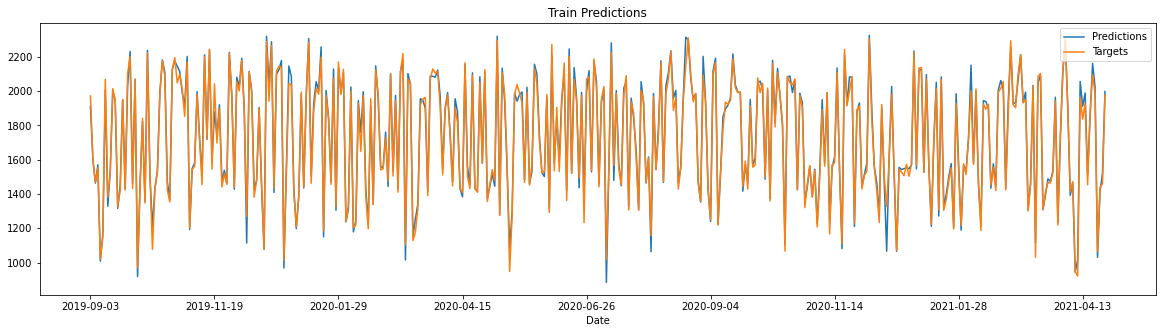

In [198]:
# Evaluate on training set
preds, ys = get_preds(train_generator, inference_m)
df = pd.DataFrame([preds.squeeze(-1), ys.squeeze(-1)], index = ["Predictions", "Targets"], columns = train_df.Date).T
df.plot(figsize = (20, 5), title = "Train Predictions");

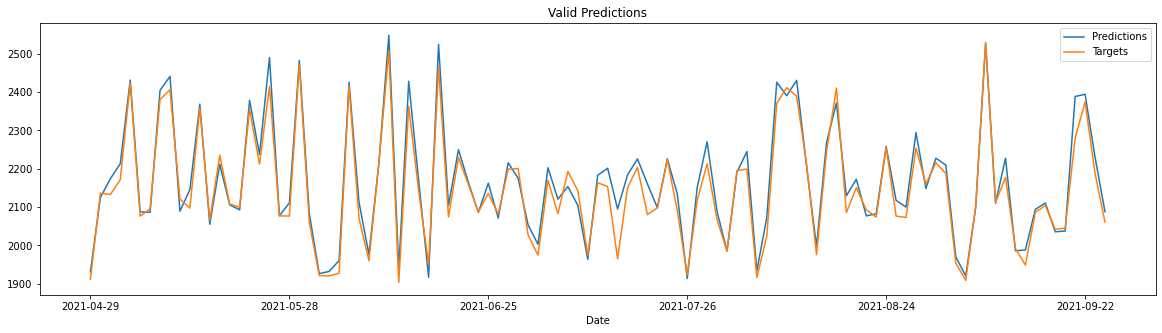

In [200]:
# Evaluate on validation set
preds, ys = get_preds(valid_generator, inference_m)
df = pd.DataFrame([preds.squeeze(-1), ys.squeeze(-1)], index = ["Predictions", "Targets"], columns = valid_df.Date).T
df.plot(figsize = (20, 5), title = "Valid Predictions");

Not bad for a starting model right? We could also use other factors like `Open`, `High`, `Low` from the reliance_df dataframe and turn this into a multi-variate time series problem. It could be for a future blog post or as homework though :p However some thoughts on how and where the implementation will change is

- When curating data, we will now be creating a list of lists as our input (one list for each variable)
- Convolution shape will change, we will have to provide as in_features = as many variables as we need to use
- For multi-step, we will have to define out_features as the number of steps for which we need predictions in the future.

The code for the entire tutorial will be available on github so feel free to fork and experiment if you liked the analysis :) I hope you had fun reading this and got to know how to use CNNs for time series analysis. If you liked what you read, you could read my [other posts here](https://elisonsherton.github.io/archive.html) and connect with me on [twitter here](https://twitter.com/ElisonSherton). 

# References
1. [Github code implementation](https://github.com/ElisonSherton/fastbook_sessions)
2. [CNNs for time series forecasting by Jason Brownlee](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/)
3. [nsepy - python API to get info for NSE shares](https://nsepy.xyz/)
4. [Pytorch book reading group](https://community.wandb.ai/t/5-pytorch-book-thread-sunday-26th-sept-8am-pt/743)